In [14]:
from influxdb_client import InfluxDBClient
import pandas as pd
from utils.singleton import SingletonInstance

class InfluxConnector(metaclass=SingletonInstance):
    def __init__(self, url: str, token: str, org: str, bucket: str) -> None:
        self.client = InfluxDBClient(url=url, token=token, org=org)
        self.query_api = self.client.query_api()
        self.bucket = bucket

    def __create_query(self, tagnames: str | list[str], start: str, end: str):
        if isinstance(tagnames, str):
            tagnames = [tagnames]
        tag_conditions = " or ".join([f'r["tagName"] == "{tagname}"' for tagname in tagnames])
        query = f'''
            from(bucket: "{self.bucket}")
            |> range(start: {start}, stop: {end})
            |> filter(fn: (r) => {tag_conditions})
            |> keep(columns: ["_time", "_value", "tagName"])
        '''
        return query

    def __parse_influx_res(self, tables) -> pd.DataFrame:
        records = []
        for table in tables:
            for record in table.records:
                records.append({
                    "_time": record.get_time(),
                    "_value": record.get_value(),
                    "tagName": record.values.get("tagName")
                })
        if not records:
            return pd.DataFrame()
        df = pd.DataFrame(records)
        return df

    def load_from_influx(self, tagnames: str | list[str], start: str, end: str) -> pd.DataFrame:
        query = self.__create_query(tagnames, start, end)
        tables = self.query_api.query(query)
        df = self.__parse_influx_res(tables)
        if not df.empty:
            df['_time'] = pd.to_datetime(df['_time'], utc=True)
            df['_time'] = df['_time'].dt.tz_convert('Asia/Seoul')
            df.set_index('_time', inplace=True)
            # 태그별로 데이터를 분리하여 처리
            dfs = []
            for tagname in tagnames:
                tag_df = df[df['tagName'] == tagname].resample('5S').first().dropna().reset_index()
                dfs.append(tag_df)
            if dfs:
                resampled_df = pd.concat(dfs, axis=0)
                return resampled_df
        return pd.DataFrame()

# # 사용 예시
# url = "http://localhost:8086"
# token = "TwrNN4J0ablMZFPFRB9GsUahs-uESVsM6WU0KKtY-jvJrFbhnxt7atnPg2wyU801B2GbFprJtomq5N1jog9uAg=="
# org = "gaonpf"
# bucket = "thermal_data"
# tagname = ["1"]


# 사용 예시
url = "http://192.168.10.60:8086"
token = "tzxpkRANOkRZsCxEDEDyxKHNFTzt6pIQYJcJY5o_9wCM0QNaTfxuKWstSYMzZnCe7lBTv0Ai7flewVI4CuqILA=="
org = "gaonpf"
bucket = "thermal_data"
tagname = ["1", "2", "3"]

connector = InfluxConnector(url=url, token=token, org=org, bucket=bucket)
df = connector.load_from_influx(tagnames=tagname, start="2024-08-08T11:17:00Z", end="2024-08-08T15:17:00Z")
print(df.tail(10))

Empty DataFrame
Columns: []
Index: []


In [13]:
test_df = list(df[df['tagName']=='1']['_value'])

KeyError: 'tagName'

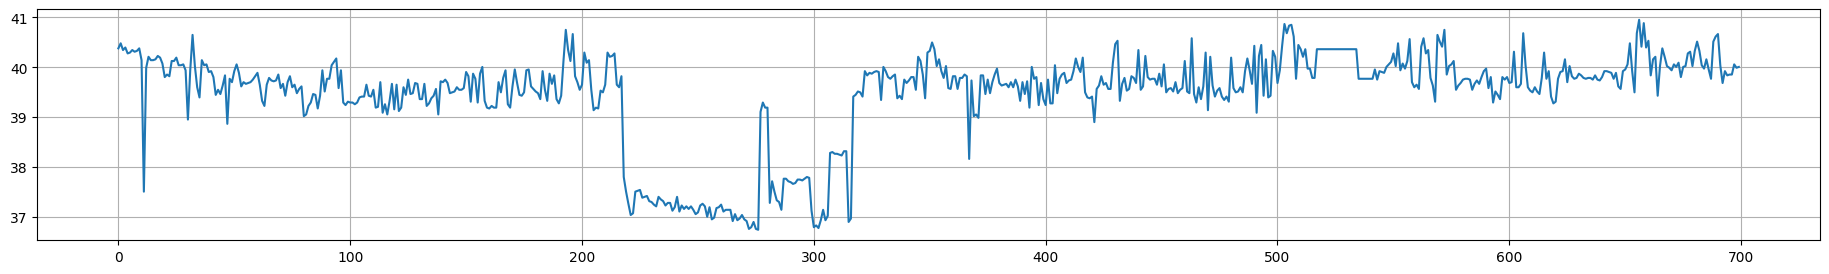

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(23,3))
plt.plot(test_df)
plt.grid()
plt.show()

In [10]:
import itertools

p = range(0,3)
d = range(0,3)
q = range(0,3)
pdq = list(itertools.product(p, d,q))

aic = []
for i in pdq:
    model = ARIMA(test_df, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
    
# Search optimal parameters
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

NameError: name 'ARIMA' is not defined

In [12]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 학습
model = ARIMA(test_df, order=(2,1,2))
model_fit = model.fit()

# 예측 기간 설정 (다음 50 스텝 예측)
forecast_steps = 720
forecast = model_fit.forecast(steps=forecast_steps)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_df)), test_df, label='Observed Temperature', color='blue')
plt.plot(range(len(test_df), len(test_df) + forecast_steps), forecast, label='Forecasted Temperature', color='red', linestyle='--')
plt.grid()
plt.show()


NameError: name 'test_df' is not defined

In [ ]:
@app.get("/train_predict/")
async def train_predict(tagname: str, start: str, end: str, forecast_steps: int = 10):
    # InfluxDB 연결 설정
    url = server_info['influx_url']
    token = server_info['influx_token']
    org = server_info['influx_org']
    bucket = server_info['influx_bucket']
    
    connector = InfluxConnector(url=url, token=token, org=org, bucket=bucket)
    
    # 데이터 로드
    df = connector.load_from_influx(tagnames=[tagname], start=start, end=end)
    
    if df.empty:
        return {"error": "No data found for the specified period."}
    
    # ARIMA 모델 학습
    values = df['_value'].tolist()
    model = ARIMA(values, order=(3, 0, 2))
    model_fit = model.fit()

    # 예측
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # 예측 결과를 반환
    return {
        "observed": values,
        "forecast": forecast.tolist()
    }